# Нотбук с демо по расчету ЗП

Основная задача - построить сервис, который может прогнозировать ЗП, основываясь на данных по профессии, региону размещения, графику работы и другим дотсупным данным.

Требования к модели: модель должна быть интерпетируемой, т.е. мы дожны уметь показать Пользователю основные факторы и их вес в формировании зарплаты. Второе требование - метрика mape <= 0.2.

Основные этапы работы:

1. **Сбор данных**. Данные, которые используються в текущей тетради, можно обогатить, использую API с площадок:
[hh](https://github.com/hhru/api/blob/master/docs/general.md), [труд всем](https://trudvsem.ru/opendata/api), [avito](https://www.avito.ru/legal/pro_tools/public-api).



2. **EDA**. Нужно понять с какими данными работаем, какие из фичей влияют на зарплату. На этом этапе важно понять, правильно ли мы собрали данные? Не ли перекосов в распределениях по локациям? Например у нас 15к вакансий из Мск, 5к вакансий из Питера, а остальные - все остальные регионы РФ. Или у нас в выборке большой перекос в сторону популярыных профессий: кассиров и водителей, а инженеров очень мало.


3. **Обработка данных**. Нужно избавиться от выбросов, написать пайплайны для процессинга данных. Сформировать трейн и тест выборки.


4. **Моделирование**. Эксперементируем с моделями, для того чтобы выбить на тесте mape <= 0.2, не забывая что модель должна быть интерпретируемой.


5. **Валидация**. Проверяем адекватность работы модели.

# Данные по вакансиям

> В качестве **_y_** будем использовать поле **salary_from**


> Спикок кодировок регионов и тэгов - в отдельном справочнике.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")

In [3]:
plt.style.use('ggplot')

In [4]:
DATA_FOLDER = os.path.join('../data')  # путь к директории с данными

In [6]:
# data = pd.read_csv(os.path.join(DATA_FOLDER, 'data_vacancies.csv'), index_col='id', encoding='utf-8', on_bad_lines = 'skip', converters={'list_regions': eval, 'work_skills': eval})
#  'tags_id': eval
data = pd.read_csv('../data/data_vacancies.csv')
data = data.drop('salary_pay_type', axis=1)

# data['list_regions'] = data['list_regions'].apply(lambda x: eval(x))
# data['work_skills'] = data['work_skills'].apply(lambda x: eval(x))
# data['tags_id'] = data['tags_id'].apply(lambda x: eval(x))

data.head(3)

,id,custom_position,schedule,salary_from,salary_to,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,work_skills,tags_id
0,48202096,Сварщик-сборщик,полный рабочий день,60000,120000,0,любое,True,0,2,[4],"['сварочные работы', 'сборка изделий по чертеж...",NaN
1,48202097,Сварщик-монтажник,полный рабочий день,60000,120000,0,любое,True,0,2,[4],"['монтажные работы', 'строительные работы', 'э...",NaN
2,48202098,Слесарь-сборщик,полный рабочий день,60000,80000,0,любое,True,0,2,[4],"['работа на фрезерных станках', 'слесарный рем...",NaN


In [7]:
data['work_skills'][0:6].explode()

0    ['сварочные работы', 'сборка изделий по чертеж...
1    ['монтажные работы', 'строительные работы', 'э...
2    ['работа на фрезерных станках', 'слесарный рем...
3    ['комплектация товара', 'маркировка', 'стрессо...
4    ['маркировка', 'стрессоустойчивость', 'погрузо...
5        ['окрашивание волос', 'классические стрижки']
Name: work_skills, dtype: object

In [8]:
data.describe(include='all').T[['count', 'unique', 'mean']]

,count,unique,mean
id,19489.0,NaN,48505170.910411
custom_position,19489,7023,NaN
schedule,19489,6,NaN
salary_from,19489.0,NaN,58869.138848
salary_to,19489.0,NaN,88490.883935
offer_education_id,19489.0,NaN,0.351429
education_name,19489,5,NaN
education_is_base,19489,1,NaN
education_order_num,19489.0,NaN,2.474473
city_id,19489.0,NaN,22.559495


In [9]:
data.isna().sum()

id                        0
custom_position           0
schedule                  0
salary_from               0
salary_to                 0
offer_education_id        0
education_name            0
education_is_base         0
education_order_num       0
city_id                   0
list_regions              0
work_skills               0
tags_id                5999
dtype: int64

In [10]:
data['tags_id'].unique()

array([nan, '[6, 9]', '[6, 8]', '[5, 6]', '[5]', '[9]', '[5, 6, 8, 9]',
       '[6]', '[5, 6, 9]', '[6, 8, 9]', '[8, 9]', '[6, 7, 9]', '[5, 9]',
       '[5, 8, 9]', '[7]', '[7, 9]', '[5, 8]', '[8]', '[7, 8, 9]',
       '[5, 6, 7, 9]', '[5, 6, 8]', '[5, 7]', '[5, 7, 9]', '[5, 6, 7]',
       '[7, 8]', '[6, 7]', '[5, 7, 8]', '[5, 6, 7, 8, 9]', '[6, 7, 8]',
       '[5, 6, 7, 8]', '[6, 7, 8, 9]'], dtype=object)

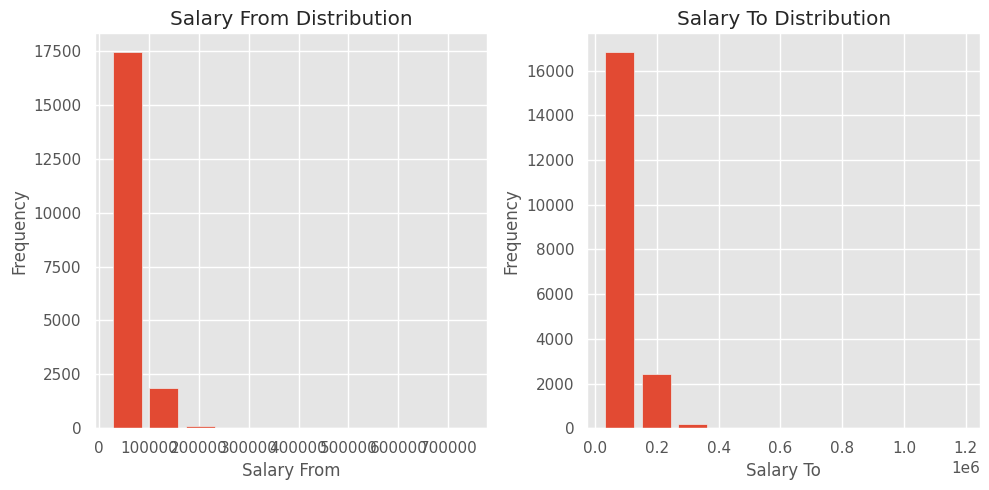

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data['salary_from'].plot(kind='hist', bins=10, rwidth=0.8, title='Salary From Distribution')
plt.xlabel('Salary From')

plt.subplot(1, 2, 2)
data['salary_to'].plot(kind='hist', bins=10, rwidth=0.8, title='Salary To Distribution')
plt.xlabel('Salary To')

plt.tight_layout()
plt.show()


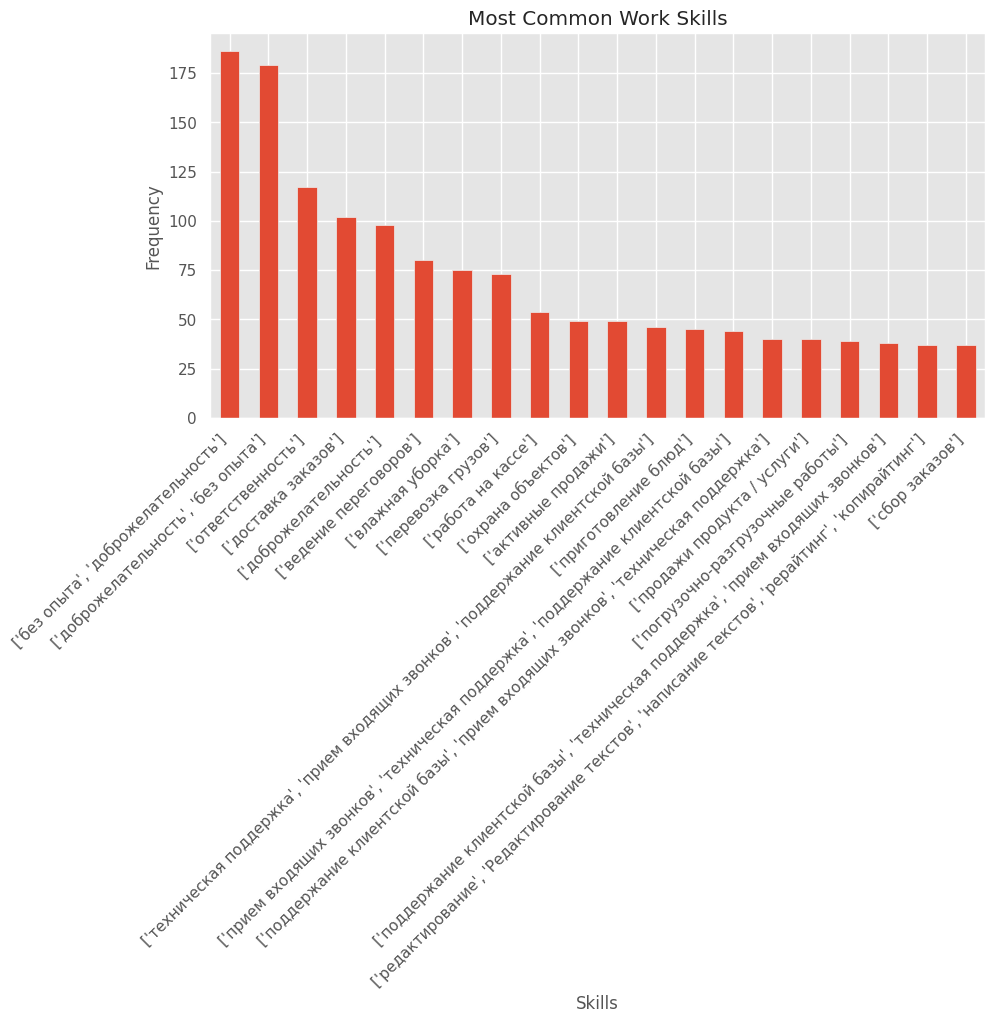

In [12]:
skills = data['work_skills'].explode()
skills.value_counts().sort_values(ascending=False)[0:20].plot(kind='bar', figsize=(10, 5))
plt.title('Most Common Work Skills')
plt.xlabel('Skills')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

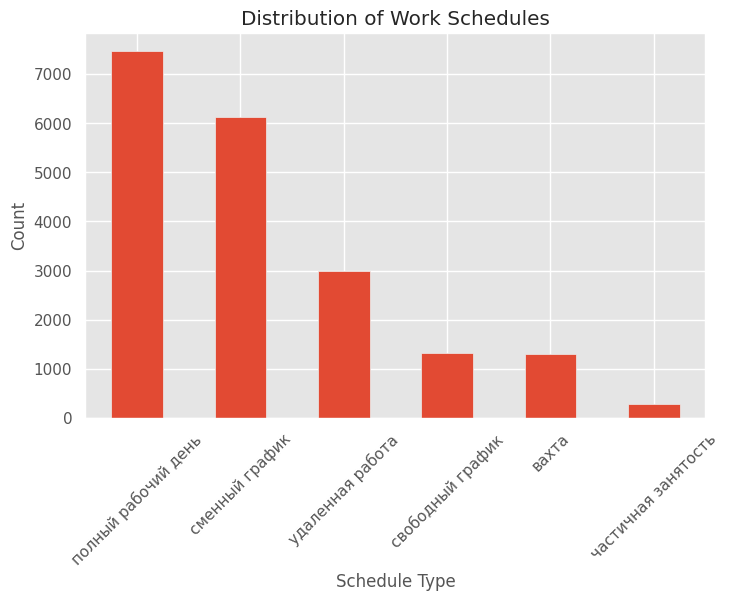

In [13]:
plt.figure(figsize=(8, 5))
data['schedule'].value_counts().plot(kind='bar')
plt.title('Distribution of Work Schedules')
plt.xlabel('Schedule Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

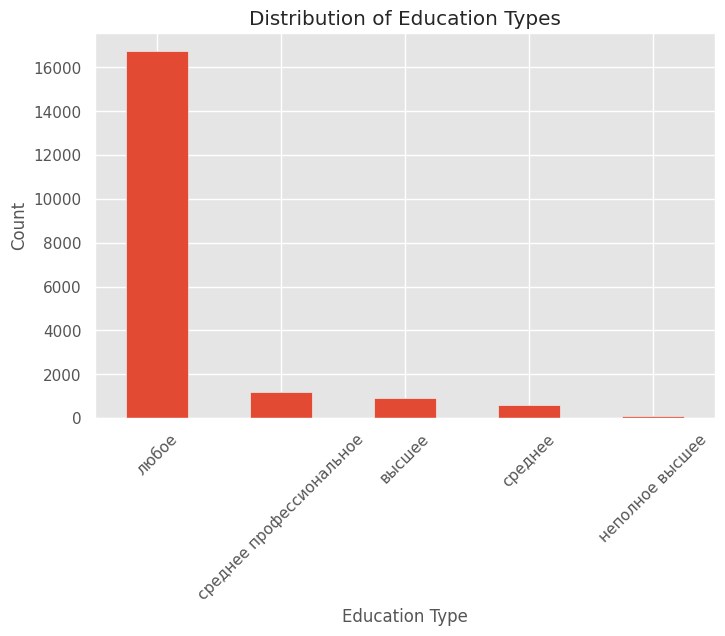

In [14]:
plt.figure(figsize=(8, 5))
data['education_name'].value_counts().plot(kind='bar')
plt.title('Distribution of Education Types')
plt.xlabel('Education Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [15]:
data['education_is_base'].value_counts()

True    19489
Name: education_is_base, dtype: int64

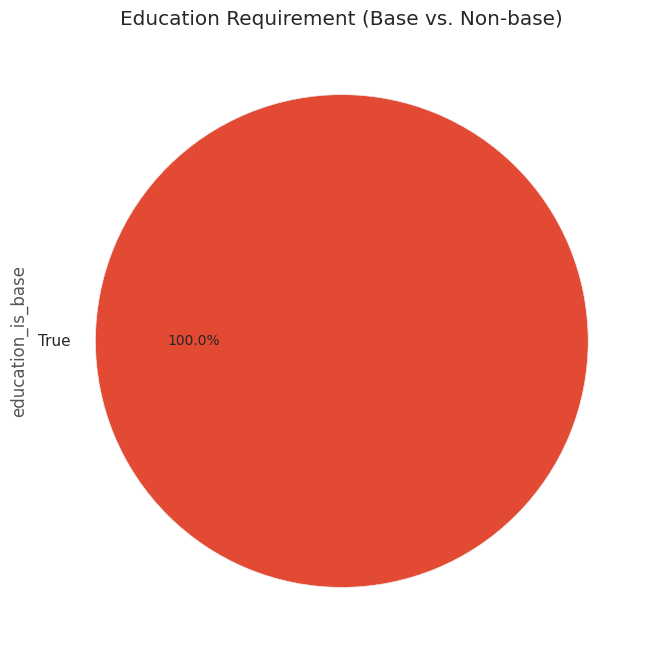

In [16]:
plt.figure(figsize=(8, 8))
data['education_is_base'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Education Requirement (Base vs. Non-base)')
plt.show()

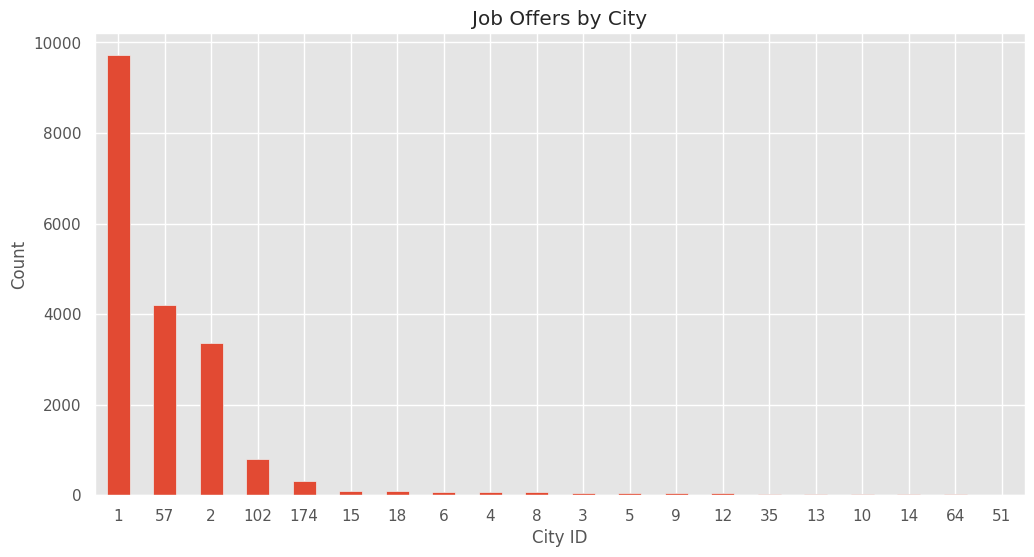

In [17]:
plt.figure(figsize=(12, 6))
data['city_id'].value_counts().sort_values(ascending=False)[0:20].plot(kind='bar')
plt.title('Job Offers by City')
plt.xlabel('City ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [46]:
data.city_id.value_counts().head(5)

1      9717
57     4210
2      3357
102     807
174     324
Name: city_id, dtype: int64

In [44]:
data['work_skills'][0:6].explode().head()

0    ['сварочные работы', 'сборка изделий по чертеж...
1    ['монтажные работы', 'строительные работы', 'э...
2    ['работа на фрезерных станках', 'слесарный рем...
3    ['комплектация товара', 'маркировка', 'стрессо...
4    ['маркировка', 'стрессоустойчивость', 'погрузо...
Name: work_skills, dtype: object

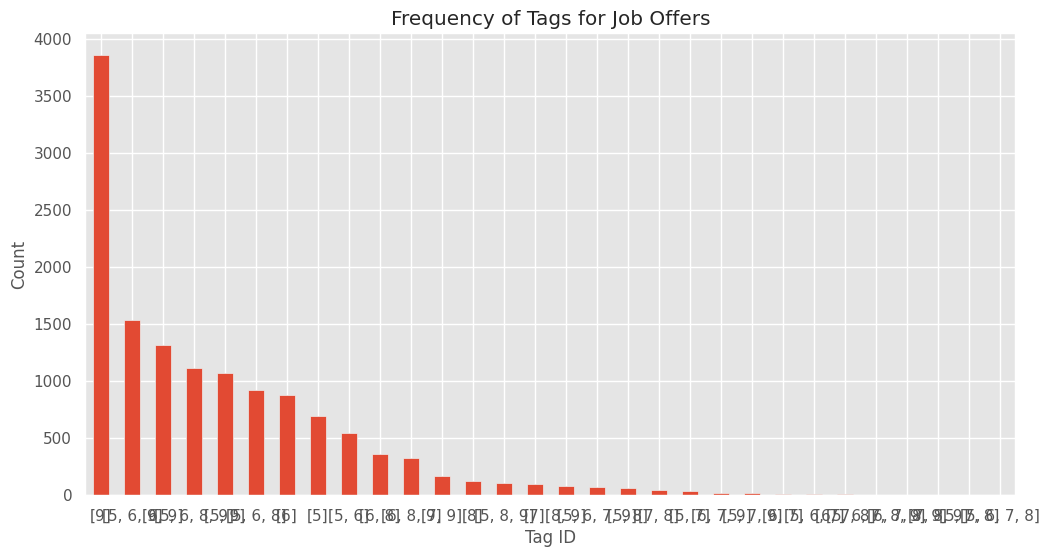

In [19]:
plt.figure(figsize=(12, 6))
tags = data['tags_id'].explode()
tags.value_counts().plot(kind='bar')
plt.title('Frequency of Tags for Job Offers')
plt.xlabel('Tag ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


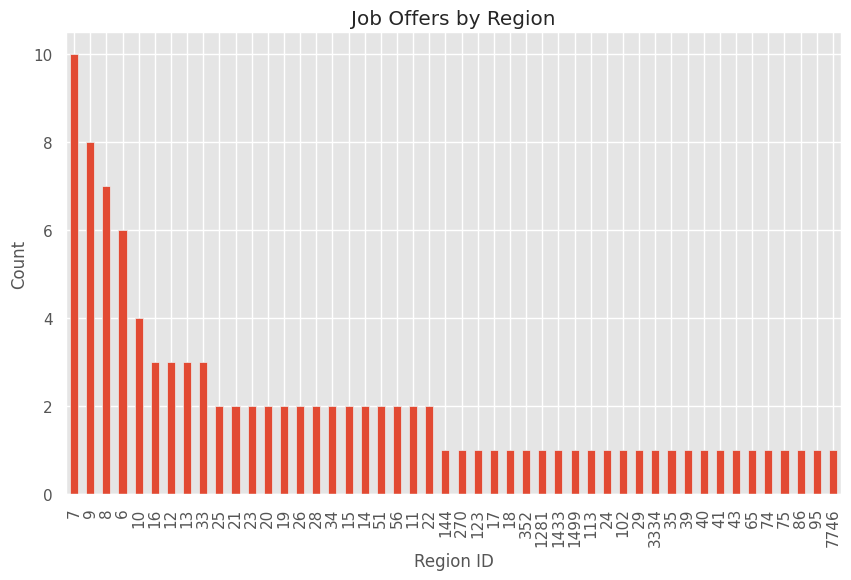

In [30]:
plt.figure(figsize=(10, 6))
regions = data['list_regions'].explode().value_counts().head(100)
regions.value_counts().plot(kind='bar')
plt.title('Job Offers by Region')
plt.xlabel('Region ID')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

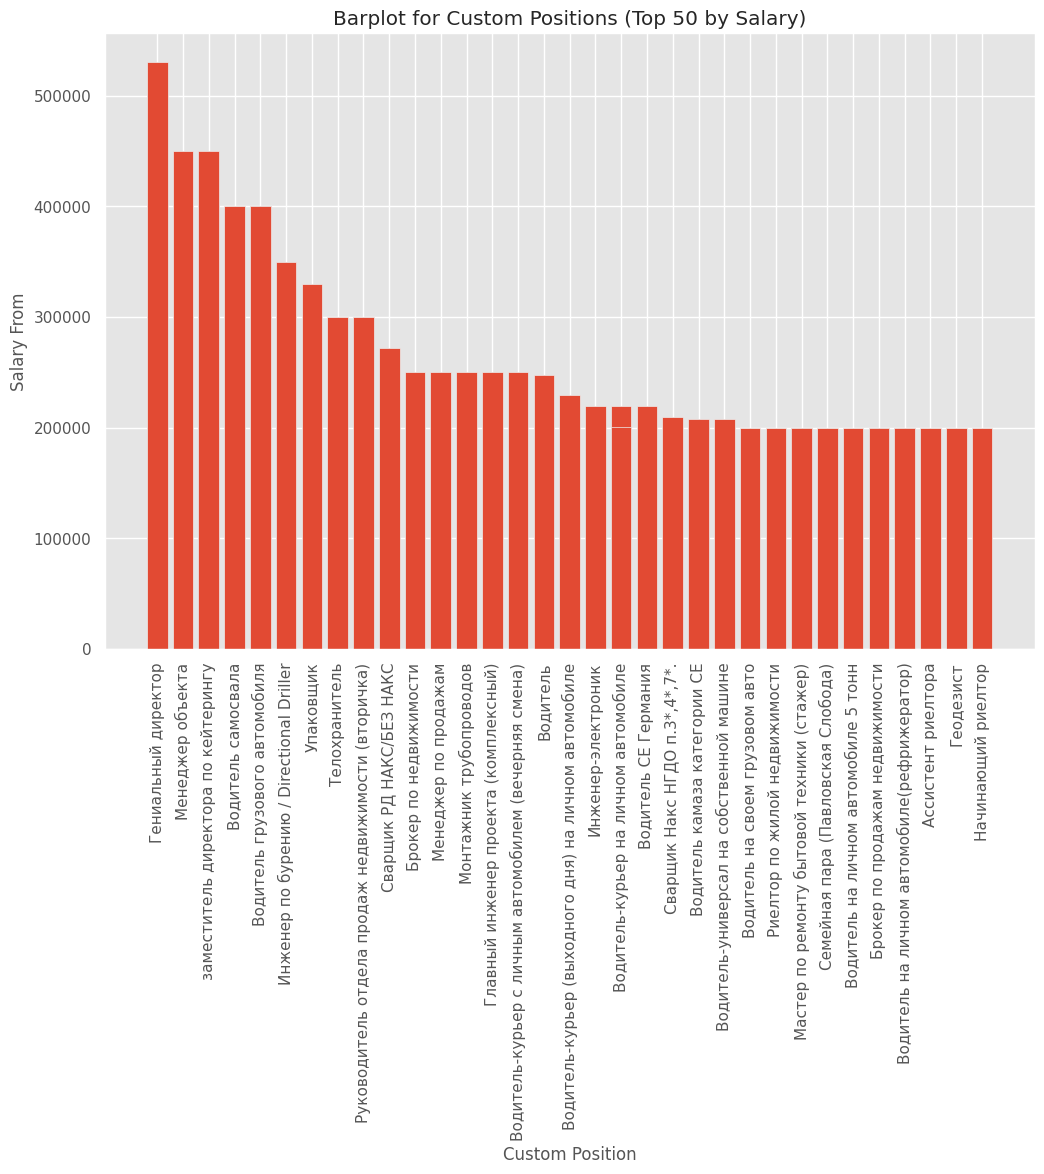

In [32]:
import matplotlib.pyplot as plt

sorted_data = data[~data['custom_position'].str.lower().str.contains("бригада")].sort_values(by='salary_from',
                                                                                             ascending=False)

top_50_data = sorted_data.head(50)

plt.figure(figsize=(12, 8))
plt.bar(top_50_data['custom_position'], top_50_data['salary_from'])

plt.title('Barplot for Custom Positions (Top 50 by Salary)')
plt.xlabel('Custom Position')
plt.ylabel('Salary From')
plt.xticks(rotation=90)
plt.grid(True)

plt.show()

#### Профессии

In [33]:
top20_profs = data['custom_position'].value_counts(dropna=False).nlargest(20)

top20_profs

Продавец-кассир                                                     409
Менеджер по продажам                                                290
Продавец-консультант                                                238
Курьер                                                              193
Охранник                                                            134
Повар                                                               130
Разнорабочий                                                        127
Водитель по доставке документов                                     118
Грузчик                                                             118
Комплектовщик                                                       112
Работник торгового зала                                             105
Продавец                                                             96
Кладовщик                                                            96
Менеджер по работе с клиентами                                  

In [34]:
data[data['city_id'] == 1]['custom_position'].value_counts(dropna=False).nlargest(20)

Менеджер по продажам                                                                       179
Продавец-кассир                                                                            166
Курьер                                                                                     123
Продавец-консультант                                                                       115
Повар                                                                                       86
Оператор входящих звонков                                                                   80
Копирайтер                                                                                  72
Контент-менеджер                                                                            65
Менеджер социальных сетей                                                                   58
Работник торгового зала                                                                     55
Помощник копирайтера                              

In [35]:
data[data['city_id'] == 2]['custom_position'].value_counts(dropna=False).nlargest(20)

Продавец-кассир                   67
Менеджер по продажам              50
Продавец-консультант              44
Охранник                          44
Курьер                            42
Домработница приходящая           35
Уборщик, Уборщица                 28
Кладовщик                         26
Разнорабочий                      26
Уборщик/Уборщица                  21
Продавец                          21
Работник торгового зала           19
Менеджер по работе с клиентами    18
Грузчик                           18
Бариста                           17
Сборщик интернет-заказов          17
Заправщик АЗС                     15
Администратор                     15
Заместитель директора магазина    15
Автомеханик-автослесарь           15
Name: custom_position, dtype: int64

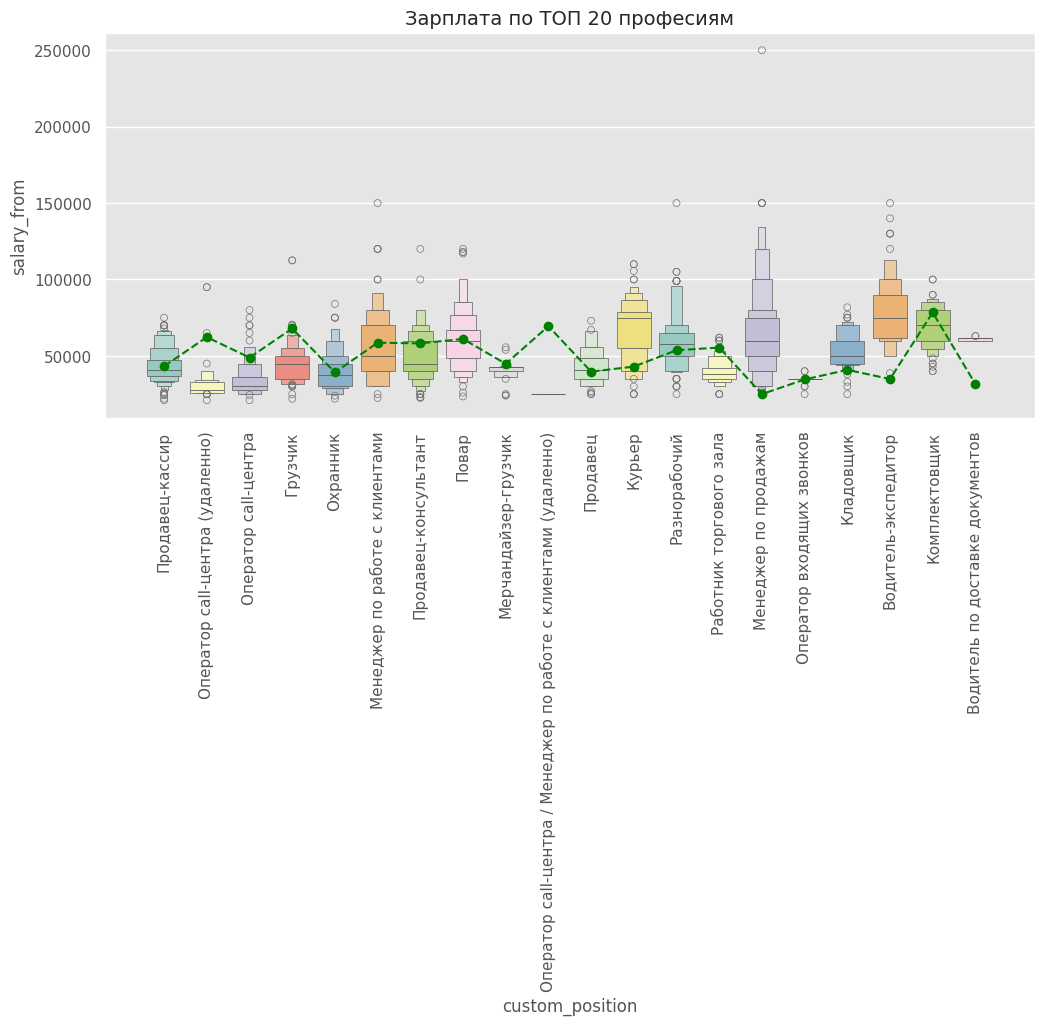

In [43]:
_df = data[data['custom_position'].isin(top20_profs.index)]
# top20_profs = data['salary_from'].sort_values(ascending=False).head(20)

profession_ranking = list(top20_profs.index)
_df = _df.sort_values('salary_from')

f, ax = plt.subplots(figsize=(12, 5))
ax = sns.boxenplot(x="custom_position", y="salary_from",
                   color="gray", hue="custom_position", palette="Set3",
                   width_method="linear", data=_df, linewidth=0.5)

ax.tick_params(axis='x', rotation=90)
ax.set_title("Зарплата по ТОП 20 професиям", fontsize=14)

means = _df.groupby("custom_position")["salary_from"].mean().loc[profession_ranking]
_ = plt.plot(range(len(profession_ranking)), means, marker="o", color="green", markersize=6, linestyle="--")

# Расчет ЗП только по професии